In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
from keras.datasets import mnist

Plan for creating Neural Network from scratch

![Alt text](image-1.png)

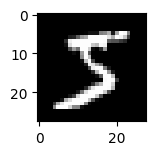

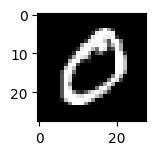

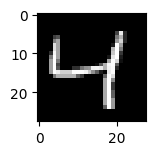

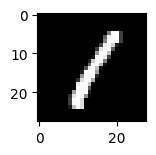

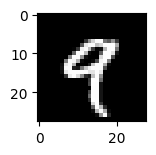

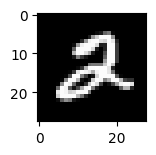

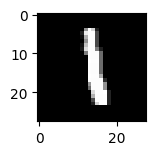

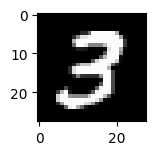

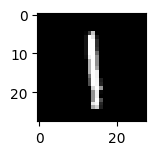

In [117]:
from matplotlib import pyplot
for i in range(9):  
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(train_X[i], cmap=pyplot.get_cmap('gray'))
    pyplot.show()

In [118]:
from keras.datasets import mnist

#loading the dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()

#printing the shapes of the vectors 
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


To calculate the error margin, we will use back prop to do that.

![Alt text](image.png)

In [4]:
# Example loading data, replace this with your actual data loading code
(train_X, train_y), (test_X, test_y) = mnist.load_data()

# Reshape the images from (number_of_images, 28, 28) to (number_of_images, 784)
train_X_flattened = train_X.reshape(train_X.shape[0], -1)
test_X_flattened = test_X.reshape(test_X.shape[0], -1)

# Normalize the pixel values to the range [0, 1]
train_X_flattened = train_X_flattened / 255.0
test_X_flattened = test_X_flattened / 255.0

# Transpose the data if each column should represent an image
train_X_flattened = train_X_flattened.T
test_X_flattened = test_X_flattened.T


In [5]:
def init_params():
    """
    Initialize the parameters of a 2-layer neural network.
    The network has 784 input features and 10 output units in each layer.
    
    Returns:
    W1, b1: Weight and bias for the first layer.
    W2, b2: Weight and bias for the second layer.
    """
    W1 = np.random.normal(size=(10, 784)) * np.sqrt(1./(784))
    #b1 = np.random.normal(size=(10, 1)) * np.sqrt(1./10)
    b1 = np.zeros((10, 1))
    W2 = np.random.normal(size=(10, 10)) * np.sqrt(1./20)
    #b2 = np.random.normal(size=(10, 1)) * np.sqrt(1./(784))
    b2 = np.zeros((10, 1))

    return W1, b1, W2, b2

def ReLU(Z):
    """
    Apply the Rectified Linear Unit (ReLU) function element-wise.
    
    Z: Input array.
    
    Returns:
    Array with ReLU applied (all negative elements set to 0).
    """
    return np.maximum(0, Z)


def LeakyReLU(Z, alpha=0.01):
    return np.where(Z > 0, Z, alpha * Z)

def softmax(Z):
    """
    Apply the softmax function to each column of the input array.
    
    Z: Input array.
    
    Returns:
    Softmax applied array.
    """
    Z -= np.max(Z, axis=0)  # Improve numerical stability
    exp_Z = np.exp(Z)
    return exp_Z / (np.sum(exp_Z, axis=0, keepdims=True) + 1e-8)

def forward_prop(W1, b1, W2, b2, X):
    """
    Perform forward propagation through the network.
    
    W1, b1: Weight and bias for the first layer.
    W2, b2: Weight and bias for the second layer.
    X: Input data (each column is an input example).
    
    Returns:
    Z1, A1: Pre-activation and post-activation values for the first layer.
    Z2, A2: Pre-activation and post-activation values for the second layer.
    """
    Z1 = W1.dot(X) + b1       # Linear step for layer 1
    A1 = LeakyReLU(Z1)             # Activation step for layer 1
    Z2 = W2.dot(A1) + b2      # Linear step for layer 2
    A2 = softmax(Z2)          # Activation step for layer 2 (softmax)
    return Z1, A1, Z2, A2

def one_hot(Y):
    """
    Convert a vector of labels to one-hot encoding.
    
    Y: Input array of labels.
    
    Returns:
    One-hot encoded matrix.
    """
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def deriv_ReLU(Z):
    """
    Compute the derivative of the ReLU function.
    
    Z: Input array.
    
    Returns:
    Array with derivatives of ReLU.
    """
    return Z > 0


def deriv_LeakyReLU(Z, alpha=0.01):
    return np.where(Z > 0, 1, alpha)

def back_prop(Z1, A1, Z2, A2, W2, X, Y):
    """
    Perform backpropagation to compute gradients.
    
    Z1, A1: Pre-activation and post-activation values for the first layer.
    Z2, A2: Pre-activation and post-activation values for the second layer.
    W2: Weight matrix for the second layer.
    X: Input data.
    Y: True labels.
    
    Returns:
    dW1, db1: Gradients of loss with respect to W1 and b1.
    dW2, db2: Gradients of loss with respect to W2 and b2.
    """
    m = Y.size
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y        # Derivative of loss with respect to Z2
    dW2 = 1 / m * dZ2.dot(A1.T) # Gradient of loss with respect to W2
    db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True) # Gradient of loss with respect to b2; corrected axis
    dZ1 = W2.T.dot(dZ2) * deriv_LeakyReLU(Z1) # Derivative of loss with respect to Z1
    dW1 = 1 / m * dZ1.dot(X.T)  # Gradient of loss with respect to W1
    db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True) # Gradient of loss with respect to b1; corrected axis

    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    """
    Update the parameters of the network using gradient descent.
    
    W1, b1: Current weight and bias for the first layer.
    W2, b2: Current weight and bias for the second layer.
    dW1, db1: Gradients for W1 and b1.
    dW2, db2: Gradients for W2 and b2.
    alpha: Learning rate.
    
    Returns:
    Updated W1, b1, W2, b2.
    """
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * np.reshape(db1, (10, 1))
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * np.reshape(db2, (10, 1))

    return W1, b1, W2, b2


In [6]:
def get_predictions(A2):
    """
    Generate predictions from the output layer's activations.

    A2: The output activations from the last layer of the neural network, 
        where each column corresponds to the activations for a given input example.

    Returns:
    An array of predicted class labels for each input example.
    """
    return np.argmax(A2, 0)  # np.argmax returns the indices of the max values along axis 0.

def get_accuracy(predictions, Y):
    """
    Calculate the accuracy of predictions against the true labels.

    predictions: An array of predicted class labels.
    Y: The true labels.

    Returns:
    The accuracy as a float.
    """
    print(predictions, Y)  # Optionally print the predictions and true labels for inspection.
    return np.sum(predictions == Y) / Y.size  # Calculate the proportion of correct predictions.

def compute_loss(A2, Y):
    m = Y.shape[1]
    loss = -np.sum(Y * np.log(A2)) / m
    return loss

def gradient_descent(X, Y, iterations, alpha):
    """
    Perform gradient descent to train the neural network.

    X: Input data, where each column is an input example (e.g., a flattened image).
    Y: True labels for the input data.
    iterations: The number of iterations to train the network.
    alpha: The learning rate.

    Returns:
    The final weights and biases after training.
    """
    W1, b1, W2, b2 = init_params()  # Initialize parameters.
    for i in range(iterations):
        # Forward propagation.
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)

        # Backward propagation.
        dW1, db1, dW2, db2 = back_prop(Z1, A1, Z2, A2, W2, X, Y)

        # Update parameters.
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)

        # Print accuracy every 50 iterations.
        if i % 50 == 0:
            loss = compute_loss(A2, one_hot(Y))
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print("Iteration: ", i, "Loss: ", loss, "Accuracy: ", get_accuracy(predictions, Y))
    return W1, b1, W2, b2


In [7]:
alpha = 0.05
iterations = 2500

In [8]:
W1, b1, W2, b2 = gradient_descent(train_X_flattened, train_y, iterations, alpha)

Iteration:  0
[9 2 2 ... 2 2 2] [5 0 4 ... 5 6 8]
Iteration:  0 Loss:  2.331273044823365 Accuracy:  0.09881666666666666
Iteration:  50
[9 0 2 ... 8 0 6] [5 0 4 ... 5 6 8]
Iteration:  50 Loss:  1.7601530802522207 Accuracy:  0.52695
Iteration:  100
[5 0 4 ... 8 6 8] [5 0 4 ... 5 6 8]
Iteration:  100 Loss:  1.2050710770591375 Accuracy:  0.72975
Iteration:  150
[5 0 4 ... 8 6 8] [5 0 4 ... 5 6 8]
Iteration:  150 Loss:  0.8523594962207632 Accuracy:  0.79665
Iteration:  200
[5 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
Iteration:  200 Loss:  0.6748250142747562 Accuracy:  0.8309
Iteration:  250
[3 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
Iteration:  250 Loss:  0.5780187240594908 Accuracy:  0.8511833333333333
Iteration:  300
[3 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
Iteration:  300 Loss:  0.5176247105607742 Accuracy:  0.8640833333333333
Iteration:  350
[3 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
Iteration:  350 Loss:  0.47671394259281197 Accuracy:  0.8724666666666666
Iteration:  400
[3 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
Iterat

In [16]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)

    return predictions

def test_prediction(index, W1, b1, W2, b2):
    # Extracting the image and reshaping it to column vector
    current_image = train_X[index].reshape(784, 1) / 255.0
    prediction = make_predictions(current_image, W1, b1, W2, b2)
    label = train_y[index]
    
    print("Prediction: ", prediction[0])  # [0] to get the scalar value
    print("Label: ", label)

    # Reshaping the image for visualization
    current_image = current_image.reshape((28, 28))
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  4
Label:  4


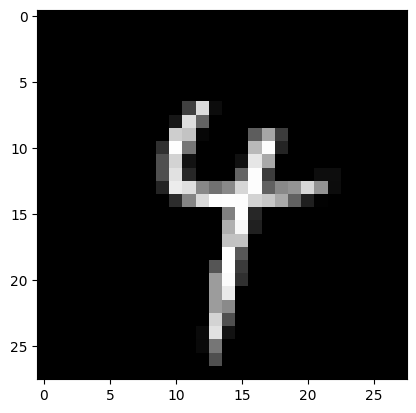

In [327]:
test_prediction(412, W1, b1, W2, b2)

In [12]:
import cv2
import os

In [13]:
from skimage import util 

In [27]:
def save_processed_image(image, path, name):
    if not os.path.exists(path):
        os.makedirs(path)
    file_name = os.path.join(path, name + ".png")
    cv2.imwrite(file_name, image)
    print(f"Saved processed image to {file_name}")

In [288]:
# Function to preprocess the frame for digit recognition
def preprocess_frame(frame, model_input_size=(28, 28)):
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image
    _, thresh = cv2.threshold(blurred, 90, 255, cv2.THRESH_BINARY_INV)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # Assuming the largest contour is the digit
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)

        # Crop and resize the image to fit model input size
        digit = gray[y:y + h, x:x + w]
        resized_digit = cv2.resize(digit, model_input_size)

        # Normalize and reshape for the model
        normalized_digit = resized_digit / 255.0
        reshaped_digit = normalized_digit.reshape(784, 1)
        return reshaped_digit

    return np.zeros((784, 1))  # Return an empty image if no contour is found






In [424]:
def preprocess_frame(frame, model_input_size=(28, 28)):
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Resize the image to fit model input size
    resized_digit = cv2.resize(blurred, model_input_size)

    # Normalize and reshape for the model
    normalized_digit = resized_digit / 255.0
    reshaped_digit = normalized_digit.reshape(784, 1)
    return reshaped_digit


In [428]:
def preprocess_frame(frame, model_input_size=(28, 28)):
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Optional: Invert colors if your webcam captures black digits on a white background
    gray = cv2.bitwise_not(gray)

    # Resize the image to fit model input size, maintaining aspect ratio
    height, width = gray.shape
    if height > width:
        scale = model_input_size[0] / height
    else:
        scale = model_input_size[1] / width
    scaled_size = (int(width * scale), int(height * scale))
    scaled_gray = cv2.resize(gray, scaled_size, interpolation=cv2.INTER_AREA)

    # Add padding to make the image square
    delta_w = model_input_size[1] - scaled_size[0]
    delta_h = model_input_size[0] - scaled_size[1]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    padded_gray = cv2.copyMakeBorder(scaled_gray, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    # Apply Gaussian blur to reduce noise (optional, depending on your use case)
    blurred = cv2.GaussianBlur(padded_gray, (5, 5), 0)

    # Normalize pixel values
    normalized_digit = padded_gray / 255.0
    reshaped_digit = normalized_digit.reshape(784, 1)
    return reshaped_digit


In [429]:
# Function to capture and process images from the webcam
def capture_and_predict():
    cap = cv2.VideoCapture(0)

    # Define the region of interest (ROI) dimensions
    ROI_size = 200  # Size of the ROI square
    x_start = int((cap.get(cv2.CAP_PROP_FRAME_WIDTH) - ROI_size) / 2)
    y_start = int((cap.get(cv2.CAP_PROP_FRAME_HEIGHT) - ROI_size) / 2)

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            break
        
        # Draw a box on the frame to indicate the ROI
        cv2.rectangle(frame, (x_start, y_start), (x_start + ROI_size, y_start + ROI_size), (0, 255, 0), 3)

        # Extract the ROI for digit recognition
        ROI = frame[y_start:y_start + ROI_size, x_start:x_start + ROI_size]

        # Preprocess the frame
        processed_frame = preprocess_frame(ROI)

        # Predict the digit
        prediction = make_predictions(processed_frame, W1, b1, W2, b2)
        predicted_digit = prediction[0]

        # Display the prediction on the frame
        cv2.putText(frame, f'Predicted Digit: {predicted_digit}', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        
        cv2.imshow('Digit Recognition', frame)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

In [36]:
def preprocess_frame(frame, model_input_size=(28, 28), save_image=False, image_path='images/processed_images/', image_name='processed_img'):
    #test_image = cv2.imread(frame, cv2.IMREAD_GRAYSCALE)

    img_resized = cv2.resize(frame, (28,28), interpolation=cv2.INTER_LINEAR)
    img_resized = cv2.bitwise_not(img_resized)
    
    # Save the processed image if required
    if save_image:
        save_processed_image(img_resized, image_path, image_name)

    return img_resized

In [422]:
def preprocess_frame(ROI, save_image=False, image_path='', image_name='image'):
    # Convert to grayscale
    gray_image = cv2.cvtColor(ROI, cv2.COLOR_BGR2GRAY)
    
    # Resize the image to 28x28
    resized_image = cv2.resize(gray_image, (784, 10))

    # Invert the grayscale image
    inverted_image = cv2.bitwise_not(resized_image)

    # Transpose the image (swap rows and columns)
    transposed_image = np.transpose(inverted_image)

    # Flatten the transposed image
    flattened_transposed_image = transposed_image.flatten()

    # Save the processed image
    if save_image:
        cv2.imwrite(f'{image_path}/{image_name}.png', inverted_image)

    return inverted_image

In [19]:

def preprocess_frame(frame):
    """
    Preprocess the frame to match MNIST dataset format.

    frame: Captured image from the camera.
    
    Returns:
    Processed image ready for prediction.
    """
    # Convert to grayscale
    if len(frame.shape) == 3 and frame.shape[2] == 3:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Resize to 28x28 (MNIST format)
    frame_resized = cv2.resize(frame, (28, 28), interpolation=cv2.INTER_AREA)

    # Invert colors if necessary (digit should be white on black background)
    frame_inverted = cv2.bitwise_not(frame_resized)

    # Normalize pixel values to be between 0 and 1
    frame_normalized = frame_inverted / 255.0

    # Flatten the image to a 784-element array
    frame_flattened = frame_normalized.flatten().reshape(784, 1)

    return frame_flattened



In [31]:
import cv2
import matplotlib.pyplot as plt

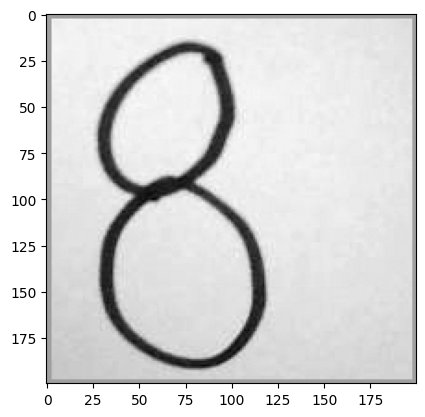

In [32]:
# Load sample image 
file = r'E:\CodingProjects\Python\ML-MNIST\images\processed_images\processed_img_2.png'
test_image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)

# Preview sample image
plt.imshow(test_image, cmap='gray')

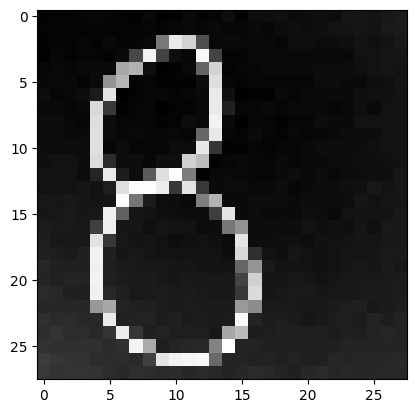

In [33]:
img_resized = cv2.resize(test_image, (28,28), interpolation=cv2.INTER_LINEAR)
img_resized = cv2.bitwise_not(img_resized)

plt.imshow(img_resized, cmap='gray')

In [29]:
def capture_and_predict(W1, b1, W2, b2):
    cap = cv2.VideoCapture(0)
    ROI_size = 200
    save_next_frame = False
    frame_count = 0

    while True:
        ret, frame, ROI = capture_frame(cap, ROI_size)
        if not ret:
            capture_and_predict(W1, b1, W2, b2)

        # Check for space bar press to save the next frame
        key = cv2.waitKey(10)
        if key == 32:  # Space bar key code
            save_next_frame = True

        processed_ROI = preprocess_frame(ROI, save_image=save_next_frame, 
                                         image_path='images/processed_images/', 
                                         image_name='processed_img_{}'.format(frame_count))

        # Reset save_next_frame after saving
        if save_next_frame:
            save_next_frame = False
            frame_count += 1

        predicted_digit = make_predictions(processed_ROI, W1, b1, W2, b2)[0]
        display_prediction(frame, predicted_digit, ROI_size)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

def capture_frame(cap, ROI_size):
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame")
        return False, frame, None

    x_start, y_start = calculate_ROI_start(cap, ROI_size)
    ROI = frame[y_start:y_start + ROI_size, x_start:x_start + ROI_size]
    draw_ROI(frame, x_start, y_start, ROI_size)
    return True, frame, ROI

def calculate_ROI_start(cap, ROI_size):
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    x_start = (frame_width - ROI_size) // 2
    y_start = (frame_height - ROI_size) // 2
    return x_start, y_start

def draw_ROI(frame, x_start, y_start, ROI_size):
    cv2.rectangle(frame, (x_start, y_start), (x_start + ROI_size, y_start + ROI_size), (0, 255, 0), 3)

def display_prediction(frame, predicted_digit, ROI_size):
    cv2.putText(frame, f'Pred: {predicted_digit}', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.imshow('Digit Recognition', frame)


In [37]:
# Make sure to initialize your model parameters (W1, b1, W2, b2) before calling this function
capture_and_predict(W1, b1, W2, b2)

ValueError: shapes (10,784) and (28,28,3) not aligned: 784 (dim 1) != 28 (dim 1)